<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install lib**

In [3]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.8 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=54157eb1a8e61f090c72e9f642c7fc80dc92875315560d6ca174d942b458bf4c
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=bc706e354d47cad515f0de2a4d2140a719f4f0733c49384166fdd2fdacdf8ace
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [5]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [6]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 35.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=38ef08c3b1406859c77d6fc6364b30e509ec5877eb335362f9e7457547d9f307
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=d93ff77750bc05dabe223a2f40bc84961254570a2f75e53642e56a69d20deff0
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=1068

# **Processing data**

In [8]:
size_data_test = 10
summary_task_original_new = []

In [9]:
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/02.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/04.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/10.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/13.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/14.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/15.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/19.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/03.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/08.txt


In [11]:
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """

  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""
  summary_taskDict = []
  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      # print("\n\n path_file:",path_file)
      # print("\n\n lines:",lines)
      for line in lines:
          line = line.strip()

          if "NOI_DUNG_TOM_TAT" in line:
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif "NHIEM_VU" in line:#line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          # new code
          elif "NGUOI_LAM" in line: #line.startswith("NGUOI_LAM"):
              summary_taskDict.append({ "people": "", "content": "", "time": ""})
              cnt = 20
              line = line.replace("NGUOI_LAM", "")
              line = line.replace(":", "")
          elif "NOI_DUNG_CV" in line: #line.startswith("NOI_DUNG_CV"):
              cnt = 21
              line = line.replace("NOI_DUNG_CV", "")
              line = line.replace(":", "")
          elif "THOI_GIAN" in line: #line.startswith("THOI_GIAN"):
              cnt = 22
              line = line.replace("THOI_GIAN", "")
              line = line.replace(":", "")
          #end
          elif "NOI_DUNG_GOC" in line: #line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")

          line += " "
          # line  = line.replace("..", ". ")
          if line:
            if cnt == 1:
              summary_content += line
            #elif cnt == 2:
            #  summary_task += line
            elif cnt == 20:
              summary_taskDict[-1]["people"] += line
            elif cnt == 21:
              summary_taskDict[-1]["content"] += line
            elif cnt == 22:
              summary_taskDict[-1]["time"] += line

            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  summary_task_original_new.append({'file' : path_file,
          'summary_task': summary_taskDict})

  return {'file' : path_file,
          # 'summary_task': summary_taskDict,
          'summary_content': summary_content,
          'original': original}

In [ ]:
# summary_task_original_new = []
# txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/02.txt")
# print("data of txt: ")
# print("summary_content: ", txt['summary_content'])
# print("original: ", txt['original'])
# print("\n")

# print("data of txt: ")
# for item in summary_task_original_new:
#   # print("item: ", item)
#   for task in item['summary_task']:
#     # print("task: ", task)
#     print("\n")
#     print("people: ", task['people'])
#     print("content: ", task['content'])
#     print("time: ", task['time'])


In [12]:
def get_stop_words_vn(path):
    ret = []
    # path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
time_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-time.txt")
print("time_words", time_words)
print("task_words", task_words)

time_words [' deadline ']
task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ', ' đảm nhận ']


## **Summary task**

In [13]:
!pip install vncorenlp

In [14]:
import os
from vncorenlp import VnCoreNLP
vncorenlp_folder = '/content/drive/MyDrive/LLM_TEXT/VnCoreNLP-master/'
vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

vnlp = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner")

In [15]:
text = "Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộcHôm nay, Mai Anh và Hải Đăng đã đến thăm chị Lan tại Hà Nội. họp của ban trung tâm bàn nội "
import os
from vncorenlp import VnCoreNLP
vncorenlp_folder = '/content/drive/MyDrive/LLM_TEXT/VnCoreNLP-master/'
vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

vnlp = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner")
def getName(str):
  annotated_text = vnlp.annotate(str)
  # print ("annotated_text",annotated_text)

  person_entities = []
  for sentence in annotated_text['sentences']:
      # print (sentence)
      for entity in sentence:
          if entity["nerLabel"] == 'B-PER':
              person_entities.append(entity["form"])
  return person_entities

print(getName(text))

['Mai_Anh', 'Hải_Đăng', 'Lan']


In [16]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import re

def contains_digits(input_str):
    digit_pattern = r'\d'
    match = re.search(digit_pattern, input_str)
    return match is not None

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str):
  sentences = process_content_sentences(str, 1, 400)
  ret = []
  for sentence in sentences:
    sentencelower = sentence.lower()
    time = ""
    for wTime in time_words:
      if wTime.strip() in sentencelower:
          time = sentencelower
          try:
            if contains_digits(time):
              ret[-1]["time"] = time
              # print("time ", time)
          except:
            pass

          break
    for wTask in task_words:
      if wTask.strip() in sentencelower:
        people = getName(sentence)
        ret.append({"people": people, "content": sentencelower, "time": "" })
        break
  return ret

In [22]:
txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/15.txt")
print ("Nội dung gốc: ", txt['original'])
test_task = detectTask(txt['original'])
cnt_32 = 0
for task in test_task:
  cnt_32 += 1
  print("\n")
  print ("Nhiệm vụ thứ ", cnt_32)
  print("Người làm: ", task['people'])
  print("Nội dung nhiệm vụ: ", task['content'])
  print("thời gian: ", task['time'])

Nội dung gốc:   Hôm nay ngày 30 tháng 05 năm 2023, gia đình ông Tùng tổ chức cuộc họp gia đình để khen thưởng em  Trung vì trong năm nay Trung có nhiều thành tích đáng khen ngợi đó là: Luôn cố gắng học tập đạt kết quả cao trong kì kiểm tra cuối năm, luôn giúp đỡ bố mẹ  công việc gia đình đặc biệt là biết cảm thông, chia sẻ với các bạn có hoàn cảnh khó khăn. Gia đình quyết định thưởng cho Trung một chuyến du lịch cùng các thành viên trong gia đình . Để chuyến đi được thuận lợi và tốt đẹp, mỗi người sẽ đảm nhận một nhiệm vụ:  Hùng sẽ  đảm nhận chọn địa điểm cho gia đình tham gia chuyến hoạt động giã ngoại. Deadline 5 tháng 6, 2023. Hiền đảm nhận thuê ô tô, mua sắm dụng cụ, đồ ăn , nước , hoa quả phục vụ chuyến giã ngoại. Deadline 6 tháng 6, 2023. Trung đảm nhận việc sắp xếp, chuẩn bị đồ dùng cá nhân cho cả nhà. Deadline 7 tháng 6, 2023. Quỳnh nhận nhiệm vụ giúp đỡ Trung hoàn thành công việc được giao. Deadline 7 tháng 6, 2023. Buổi họp gia đình anh Tùng kết thúc với 100% các thành viên t

## **Get data**

In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:

test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_content"] )

summary_task_original_new = []
for path_file in test_df["file"]:
  read_content(path_file)

for task in summary_task_original_new:
  print ("task", task )

test_df 0     Gia đình ông Nguyễn Văn Tùng tổ chức cuộc họp...
1     Ban chỉ đạo trường THCS Hồng Thái họp bàn về ...
2    ﻿ Cuộc họp diễn ra tại công ty Vạn Thắng nhằm ...
3     Vào 7 giờ 15 phút ngày 24 tháng 6 năm 2023 , ...
4     ban chi uỷ chi bộ Minh Dương tổ chức cuộc   h...
5    ﻿ Lớp 11A3 tổ chức cuộc họp năm khen thưởng độ...
6     Trong cuộc họp giao nhiệm vụ của công ty Vạn ...
7     Công ty Nam Khánh  diễn ra cuộc họp quan trọn...
8     Gia đình Tuyến tổ chức cuộc họp nhằm tìm các ...
9    ﻿ Vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễ...
Name: summary_content, dtype: object
task {'file': '/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/15.txt', 'summary_task': [{'people': ' Hùng ', 'content': ' sẽ đảm nhận chọn địa điểm cho gia đình tham gia chuyến hoạt động giã ngoại ', 'time': ' Deadline 5 tháng 6, 2023  '}, {'people': ' Hiền ', 'content': ' đảm nhận thuê ô tô, mua sắm dụng cụ, đồ ăn , nước , hoa quả phục vụ chuyến giã ngoại ', 'time': ' Deadline 6 tháng 6, 2023  '}, {'peo

In [ ]:
test_data =  Dataset.from_pandas(test_df)

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

# **Inference**

In [ ]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_BBCH/"
RATIO = 0.2
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
rougel_recall = []
rougel_precision = []
rougel_f1 = []

In [ ]:
def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

## **With my model**

In [ ]:
myModelName = 'Custom "Custom PhoBERT"'

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-30000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [ ]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]
# summary_task_original = results["summary_task"]


print ("result_summary_content: ",result_summary_content[0] )

print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
# print ("summary_task: ",summary_task_original[0] )
print ("original: ",test_data[0]["original"] )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  Trong gia định điềm gia gia gia facebook Nguyễn Tùng vừa khẳng khách thực
file:  /content/drive/MyDrive/LLM_TEXT/dataset/BBCH/15.txt
summary_conten:   Gia đình ông Nguyễn Văn Tùng tổ chức cuộc họp gia đình để khen thưởng em Nguyễn Văn Trung. Vì trong năm nay Trung có nhiều thành tích đáng khen ngợi đó là: cố gắng học tập đạt kết quả cao, giúp đỡ bố mẹ, cảm thông, chia sẻ với các bạn có hoàn cảnh khó khăn.  
original:   Hôm nay ngày 30 tháng 05 năm 2023, gia đình ông Tùng tổ chức cuộc họp gia đình để khen thưởng em  Trung vì trong năm nay Trung có nhiều thành tích đáng khen ngợi đó là: Luôn cố gắng học tập đạt kết quả cao trong kì kiểm tra cuối năm, luôn giúp đỡ bố mẹ  công việc gia đình đặc biệt là biết cảm thông, chia sẻ với các bạn có hoàn cảnh khó khăn. Gia đình quyết định thưởng cho Trung một chuyến du lịch cùng các thành viên trong gia đình . Để chuyến đi được thuận lợi và tốt đẹp, mỗi người sẽ đảm nhận một nhiệm vụ:  Hùng sẽ  đảm nhận chọn địa điểm

In [ ]:
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data)
  result_summary_task.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': ['Hùng'], 'content': 'để chuyến đi được thuận lợi và tốt đẹp, mỗi người sẽ đảm nhận một nhiệm vụ:  hùng sẽ  đảm nhận chọn địa điểm cho gia đình tham gia chuyến hoạt động giã ngoại.', 'time': 'deadline 5 tháng 6, 2023.'}
task {'people': ['Hiền'], 'content': 'hiền đảm nhận thuê ô tô, mua sắm dụng cụ, đồ ăn , nước , hoa quả phục vụ chuyến giã ngoại.', 'time': 'deadline 6 tháng 6, 2023.'}
task {'people': [], 'content': 'trung đảm nhận việc sắp xếp, chuẩn bị đồ dùng cá nhân cho cả nhà.', 'time': 'deadline 7 tháng 6, 2023.'}
task {'people': ['Quỳnh'], 'content': 'quỳnh nhận nhiệm vụ giúp đỡ trung hoàn thành công việc được giao.', 'time': 'deadline 7 tháng 6, 2023.'}
task {'people': [], 'content': 'nga hiệu trưởng cũng chính là trưởng ban chỉ đạo phòng chống dịch bệnh thông qua nội dung thực hiện phòng bệnh và giao nhiệm vụ cho từng thành viên.', 'time': ''}
task {'people': ['Linh'], 'content': 'sau đây là nhiệm vụ cụ thể của từng người: linh sẽ đảm nhận trách nhiệm hướng dẫn 

## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]

In [ ]:
import os
import re

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) +" "
  write_data(path, 0, idx, result)

In [ ]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk

SENTENCES_COUNT = 3
path_file_stopword = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
# print(test_df)
if __name__ == "__main__":

    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    for idx, originnalTxt in enumerate(test_df["original"]):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(originnalTxt), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


    # for sentence in summarizer(parser.document, SENTENCES_COUNT):
    #     print(sentence)

0
allnumber: []
all_dot []
text_dot: []
1
allnumber: []
all_dot []
text_dot: []
2
allnumber: []
all_dot []
text_dot: []
3
allnumber: []
all_dot []
text_dot: []
4
allnumber: []
all_dot []
text_dot: ['. Ô', '. Ô', '. Ô', '. Ô']
5
allnumber: []
all_dot []
text_dot: []
6
allnumber: []
all_dot []
text_dot: []
7
allnumber: []
all_dot []
text_dot: []
8
allnumber: []
all_dot []
text_dot: []
9
allnumber: []
all_dot ['T.', 'S.']
text_dot: ['. .']


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []

    print("model: ", model)
    ret_rouge_ = rouge.compute(predictions=data_sum, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
    # for key,value in ret_rouge_.items():
    #   print(key)
    #   print(value.mid)

    getRougeMyModel(ret_rouge_)

In [ ]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)


# getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.5481990629069258 -precision 0.6143612469592861 -F1-Score 0.5374815337253525
rouge2:recall 0.2566964457597153 -precision 0.2639529339999831 -F1-Score 0.2421182783180258
rougeL:recall 0.3926876376404813 -precision 0.4269385313780028 -F1-Score 0.37721455569306617
model:  LexRankSummarizer
rouge1:recall 0.4736249499720593 -precision 0.8187856232996898 -F1-Score 0.5682678943944623
rouge2:recall 0.31002326036926686 -precision 0.550459091890776 -F1-Score 0.37740589218512427
rougeL:recall 0.358038273817026 -precision 0.6588894210207084 -F1-Score 0.4383115990142906
model:  LsaSummarizer
rouge1:recall 0.4966139070493036 -precision 0.7456828277970649 -F1-Score 0.5647688860437485
rouge2:recall 0.2515186165196336 -precision 0.4346982223383813 -F1-Score 0.2985216036054271
rougeL:recall 0.34825614713853775 -precision 0.5618704047050168 -F1-Score 0.40533285426980487
model:  LuhnSummarizer
rouge1:recall 0.4287350759571623 -precision 0.8597875391950414 -F1-Score 0.54

# **Evaluation**


In [ ]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
models.append(myModelName)
getRougeMyModel(rouge_summary_content)


Evaluation content
rouge1:recall 0.6282313598886786 -precision 0.40268942623162574 -F1-Score 0.4523706855566528
rouge2:recall 0.18259950182707657 -precision 0.11726596029091493 -F1-Score 0.13461491243267462
rougeL:recall 0.38321548432526553 -precision 0.25556474366150406 -F1-Score 0.2815394644814894


In [ ]:
# result_task_blank = blankkData(result_summary_task)
summary_task_originnal_people = []
summary_task_originnal_content = []
summary_task_originnal_time = []

summary_task_result_people = []
summary_task_result_content = []
summary_task_result_time = []
cnt_1 = 0
for task_original in summary_task_original_new:
  p_o = ""
  c_o = ""
  t_o = ""
  p_r = ""
  c_r = ""
  t_r = ""
  for oriTask in task_original['summary_task']:
    if oriTask['people']:
      p_o += ". " + oriTask['people']
    if oriTask['content']:
      c_o += ". " + oriTask['content']
    if oriTask['time']:
      t_o += ". " + oriTask['time']


  for retTask in result_summary_task[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']

  print ("p_o", p_o)
  print ("c_o", c_o)
  print ("t_o", t_o)

  print ("p_r", p_r)
  print ("c_r", c_r)
  print ("t_r", t_r)
  summary_task_originnal_people.append(p_o)
  summary_task_result_people.append(p_r)

  summary_task_originnal_content.append(c_o)
  summary_task_result_content.append(c_r)

  summary_task_originnal_time.append(t_o)
  summary_task_result_time.append(t_r)
  cnt_1 += 1
  print("\n")


p_o .  Hùng .  Hiền .  Trung .  Quỳnh 
c_o .  sẽ đảm nhận chọn địa điểm cho gia đình tham gia chuyến hoạt động giã ngoại .  đảm nhận thuê ô tô, mua sắm dụng cụ, đồ ăn , nước , hoa quả phục vụ chuyến giã ngoại .  đảm nhận việc sắp xếp, chuẩn bị đồ dùng cá nhân cho cả nhà .  giúp đỡ Trung hoàn thành công việc được giao 
t_o .  Deadline 5 tháng 6, 2023  .  Deadline 6 tháng 6, 2023  .  Deadline 7 tháng 6, 2023  .  Deadline 6 tháng 6, 2023 
p_r . Hùng. Hiền. Quỳnh
c_r . để chuyến đi được thuận lợi và tốt đẹp, mỗi người sẽ đảm nhận một nhiệm vụ:  hùng sẽ  đảm nhận chọn địa điểm cho gia đình tham gia chuyến hoạt động giã ngoại.. hiền đảm nhận thuê ô tô, mua sắm dụng cụ, đồ ăn , nước , hoa quả phục vụ chuyến giã ngoại.. trung đảm nhận việc sắp xếp, chuẩn bị đồ dùng cá nhân cho cả nhà.. quỳnh nhận nhiệm vụ giúp đỡ trung hoàn thành công việc được giao.
t_r . deadline 5 tháng 6, 2023.. deadline 6 tháng 6, 2023.. deadline 7 tháng 6, 2023.. deadline 7 tháng 6, 2023.


p_o .  Linh .  Hùng .  Hạnh . 

In [ ]:
print("Evaluation people in task")

rouge_task_result_people = rouge.compute(predictions=summary_task_result_people, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_people.items():
  print(key)
  print(value.mid)

Evaluation people in task
rouge1
Score(precision=0.7453678266178265, recall=0.7375, fmeasure=0.7073135378553336)
rouge2
Score(precision=0.5316666666666666, recall=0.5422619047619048, fmeasure=0.5084894517247458)
rougeL
Score(precision=0.7320054945054946, recall=0.7205357142857143, fmeasure=0.692450043506545)


In [ ]:
print("Evaluation content in task")

rouge_task_result_content = rouge.compute(predictions=summary_task_result_content, references=summary_task_originnal_content, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_content.items():
  print(key)
  print(value.mid)

Evaluation content in task
rouge1
Score(precision=0.7249971678618689, recall=0.9025672561890119, fmeasure=0.7724998688450031)
rouge2
Score(precision=0.6628432714014301, recall=0.8428249366403241, fmeasure=0.7122673157487134)
rougeL
Score(precision=0.659802588386365, recall=0.8472322844812015, fmeasure=0.714114853130117)


In [ ]:
print("Evaluation time in task")

rouge_task_result_time = rouge.compute(predictions=summary_task_result_time, references=summary_task_originnal_time, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_time.items():
  print(key)
  print(value.mid)

Evaluation time in task
rouge1
Score(precision=0.9916666666666668, recall=0.9666666666666668, fmeasure=0.9773809523809524)
rouge2
Score(precision=0.9826086956521738, recall=0.9565217391304348, fmeasure=0.967608695652174)
rougeL
Score(precision=0.9916666666666668, recall=0.9666666666666668, fmeasure=0.9773809523809524)


# **Draw a comparison chart**

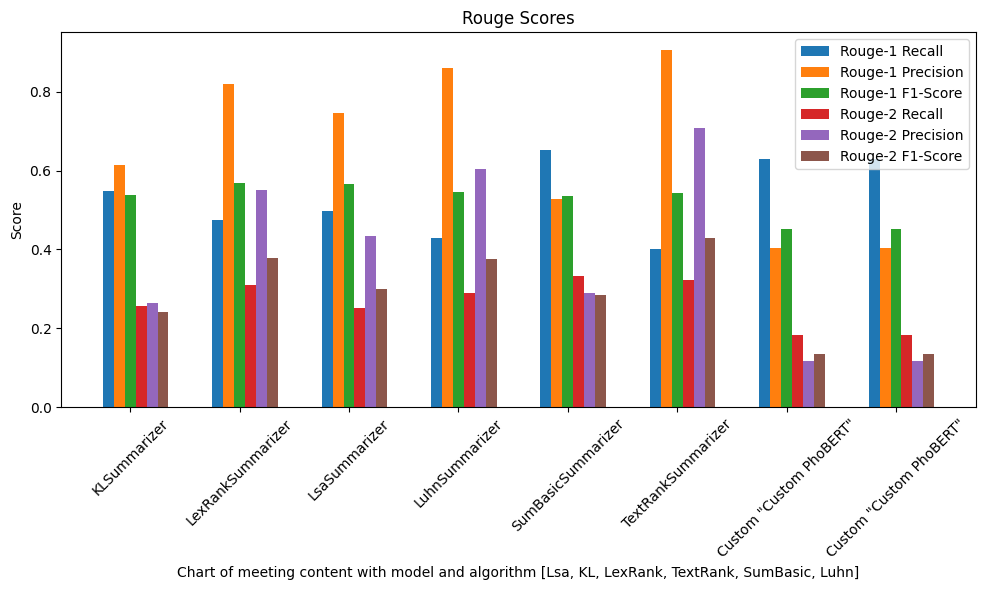

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Chart of meeting content with model and algorithm [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def getRougeTask(rouge):
  for key,value in rouge.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[0])
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall_task.append(value.mid[0])
         rouge2_precision_task.append(value.mid[1])
         rouge2_f1_task.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

In [ ]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
rouge2_recall_task = []
rouge2_precision_task = []
rouge2_f1_task = []
models_task = ["People in task", "Content in task", "Time in task"]

print ("rouge_task_result_people")
getRougeTask(rouge_task_result_people)

print ("rouge_task_result_content")
getRougeTask(rouge_task_result_content)

print ("rouge_task_result_time")
getRougeTask(rouge_task_result_time)

rouge_task_result_people
rouge1:recall 0.7453678266178265 -precision 0.7375 -F1-Score 0.7073135378553336
rouge2:recall 0.5316666666666666 -precision 0.5422619047619048 -F1-Score 0.5084894517247458
rougeL:recall 0.7320054945054946 -precision 0.7205357142857143 -F1-Score 0.692450043506545
rouge_task_result_content
rouge1:recall 0.7249971678618689 -precision 0.9025672561890119 -F1-Score 0.7724998688450031
rouge2:recall 0.6628432714014301 -precision 0.8428249366403241 -F1-Score 0.7122673157487134
rougeL:recall 0.659802588386365 -precision 0.8472322844812015 -F1-Score 0.714114853130117
rouge_task_result_time
rouge1:recall 0.9916666666666668 -precision 0.9666666666666668 -F1-Score 0.9773809523809524
rouge2:recall 0.9826086956521738 -precision 0.9565217391304348 -F1-Score 0.967608695652174
rougeL:recall 0.9916666666666668 -precision 0.9666666666666668 -F1-Score 0.9773809523809524


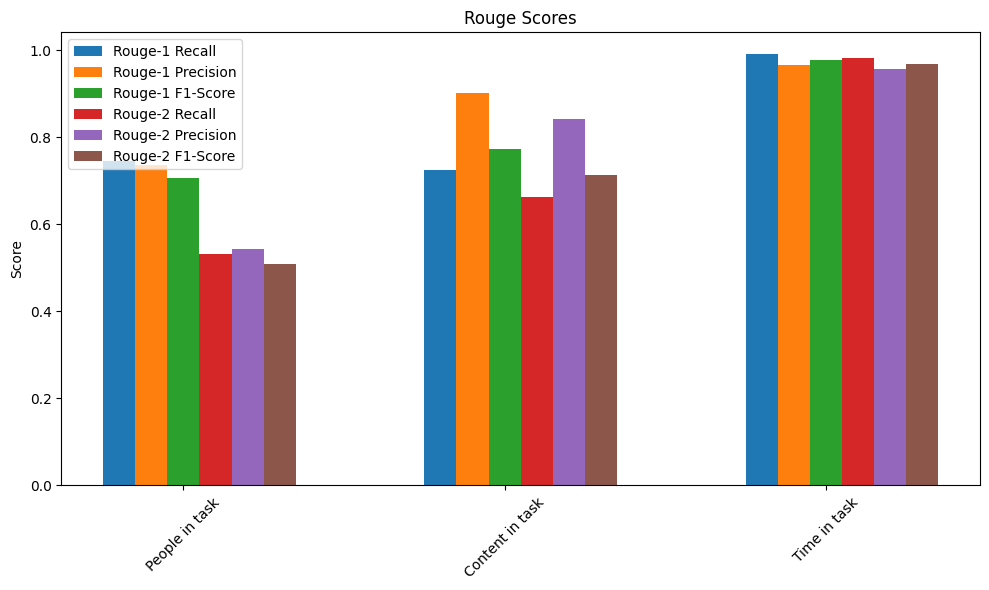

In [ ]:

import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()